# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 11
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Tuesday, April 24th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

Name: Christopher Hase

In [10]:
import numpy as np
from matplotlib import pyplot as plt

## The AM207 Cambridge Nursery

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) = \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be able to understand the distribution of $\theta$ and make appropriate estimates.

## Problem 1. Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtaining the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$


Derive the joint posterior $p(\theta, z  \vert  y)$ and sample from it using Gibbs sampling.

Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

$p(\theta,z|y)\propto p(y,z|\theta)\cdot p(\theta)$

We can use Gibbs sampling after finding the distibutions of $\theta|z,y$ and $z|\theta,y$. After some algebra, we find:

$\theta|z,y\sim Beta(a+z+y_4,b+y_2+y_3)$

$z|\theta,y\sim Bin\bigg(y_1, \dfrac{\theta}{\theta+2}\bigg)$

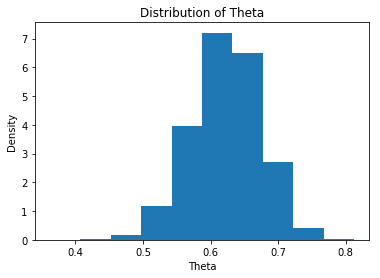

Estimated mean of theta:0.622826794876
Estimated probability of a type 4 child plant: 0.155706698719


In [90]:
# data
y1 = 125
y2 = 18
y3 = 20
y4 = 34

# beta params
a = 1
b = 1
theta = np.random.beta(a, b, 1)

# gibbs sampling
iterations = 100000
thetas = []
for iteration in range(iterations):
    z = np.random.binomial(y1, theta/(theta+2), 1)
    theta = np.random.beta(a + z + y4, b + y2 + y3, 1)
    thetas.append(theta[0])

# plot distribution of thetas
plt.hist(thetas, normed=True)
plt.title('Distribution of Theta')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.show()

# prob of type 4
print('Estimated mean of theta:' + str(np.mean(thetas)))
print('Estimated probability of a type 4 child plant: ' + str(np.mean(thetas)/4))

## Problem 2. Finding the MLE using Expectation Maximization

Treat the augmented model as a latent variable model. 

### Part A. 

Write down an expression (up to unimportant constants - you must decide what unimportant means) for each of the following:

(1) the observed data log likelihood

(2) the complete(full) data log likelihood

**Hint:** You should already have the observed data likelihood and the complete data likelihood from Problem 1, you just need to take their logs for this problem.

(3) the Auxilary function, $Q(\theta, \theta^{(t-1)})$, or the expected complete(full) data log likelihood, defined by
$$Q(\theta, \theta^{(t-1)}) = \mathbb{E}_{Z  \vert  Y=y, \Theta = \theta^{t-1}}[\text{the complete data log likelihood}]$$

In other words $Z  \vert  Y=y, \Theta = \theta^{t-1}$ is $q(z, \theta_{old})$ from lecture at the end of the E-step and $Q$ is the z-posterior expectation (at $\theta_{old}$) of the full data log likelihood, which is the ELBO minus the entropy of $q$ (which being evaluated at $\theta_{old}$ is not dependent on $\theta$ and thus irrelevant for maximization).

### Part B:

We will maximize the likelihood through Expectation Maximization (EM). In order to preform EM, we must iterate through the following steps

- (Expectation) Compute the Auxilary function, $Q(\theta, \theta^{t-1})$ (the expectation of the full data likelihood)
- (Maximization) Compute $\theta^{t} = \text{argmax}_\theta Q(\theta, \theta^{(t-1)})$

Thus, you must compute exact formulae for the following:
1. the Auxilary function, $Q(\theta, \theta^{(t-1)})$, for a given $\theta^{(t-1)}$. That is, compute the expectation of the complete data log likelihood.
2. $\theta^{t}$, by maximizing the Auxilary function $Q(\theta, \theta^{(t-1)})$.

**Hint:** You don't actually need to do any difficult optimization for the M-step. After taking the expectation of the complete data log likelihood in the E-step, match your $Q(\theta, \theta^{(t-1)})$ to the log pdf of a familiar distribution, then use the known formula for the mode of this distribution to optimize $Q(\theta, \theta^{(t-1)})$.

Use these to **estimate the MLE** of $\theta$ using EM (choose your own reasonable criterion for convergence).

### Part A

(1) $\log(p(y|\theta))=y_1\cdot\log(\theta+2)+(y_2+y_3)\cdot\log(1-\theta)+y_4\log(\theta)+c_1$

(2) $\log(p(y,z|\theta))=(y_2+y_3)\cdot\log(1-\theta)+(z+y_4)\cdot\log(\theta)+c_2$

(3) $Q(\theta, \theta^{(t-1)})=E_{Z  \vert  Y=y, \Theta = \theta^{t-1}}(\log(p(y,z|\theta))=(y_2+y_3)\cdot\log(1-\theta)+\Bigg(E(Z|Y=y,\Theta=\theta^{t-1})+y_4\Bigg)\cdot\log(\theta)+c_2$

### Part B

(1) $Q(\theta, \theta^{(t-1)})=E_{Z  \vert  Y=y, \Theta = \theta^{t-1}}(\log(p(y,z|\theta))=(y_2+y_3)\cdot\log(1-\theta)+\Bigg(y_1\cdot\dfrac{\theta^{t-1}}{\theta^{t-1}+2}+y_4\Bigg)\cdot\log(\theta)+c_2$

(2) To maximize $Q(\theta, \theta^{(t-1)})$ with respect to $\theta$ we can use the properties of the beta distribution: $\theta|y,\theta^{t-1}\sim Beta\Bigg(y_1\cdot\dfrac{\theta^{t-1}}{\theta^{t-1}+2}+y_4+1, y_2+y_3+1\Bigg)$

$\Rightarrow$ $\theta^t=\dfrac{y_1\cdot\frac{\theta^{t-1}}{\theta^{t-1}+2}+y_4}{y_1\cdot\frac{\theta^{t-1}}{\theta^{t-1}+2}+y_2+y_3+y_4}$

In [91]:
# estimate MLE of theta

# data
y1 = 125
y2 = 18
y3 = 20
y4 = 34

# initialize theta
a = 1
b = 1
theta = np.random.beta(a, b, 1)
theta_old = 1

# run EM
while abs(theta - theta_old) > 0.000000000000001:
    theta_old = theta
    theta = (((theta_old)/(theta_old+2))*y1 + y4)/(y2+y3+((theta_old)/(theta_old+2))*y1 + y4)
    
print('MLE of theta: ' + str(theta[0]))

MLE of theta: 0.626821497871
